# 👨‍🎤👨‍⚖ actor-critic for llvm-autophase task

## Problem description:

This task in based on [CompilerGym](https://compilergym.com/) environment which is designed to make compilers closer to ml optimizations. It allows ML researchers to interact with important compiler optimization problems in a language and vocabulary with which they are comfortable, and provides a toolkit for systems developers to expose new compiler tasks for ML research. 

We will focus on *llvm-autophase* task. 

The llvm-ic-v0 environment exposes LLVM's optimizing passes as a set of actions that can be applied to a particular program. The goal of the agent is to select the sequence of optimizations that lead to the greatest reduction in instruction count in the program being compiled

Compilers frequently package individual transformations as “optimization passes” which are then applied in a sequential order. Usually this order is fixed (e.g. [real world example](https://github.com/llvm/llvm-project/blob/71a8e4e7d6b947c8b954ec0763ff7969b3879d7b/llvm/lib/Transforms/IPO/PassManagerBuilder.cpp#L517-L922)). The CompilerGym LLVM environment replaces that fixed order with a sequential decision process where any pass may be applied at any stage.

## Overview of llvm environment in CompilerGym

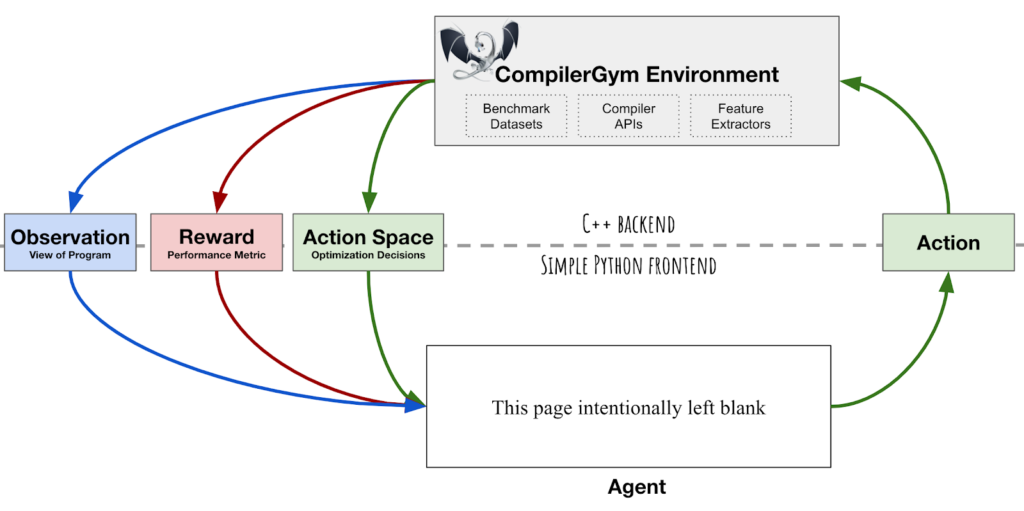

Here just some notes. For more go to [full overview](https://compilergym.com/llvm/index.html).

**Datasets.**

Load from model or add your own via `env.make_benchmark()` API.

**Observation Spaces.**

Here you can choose from a bunch of ways to record the "current state" of the compiler:


- LLVM-IR `ir`
- [InstCount](https://compilergym.com/llvm/index.html#instcount) `ic`
    - 70-dimension integer feature vector in the range [0,∞]
    - the total number of instructions
    - the total number of basic blocks
    - the total number of functions
    - The remaining features are the number of instructions of each of the 67 different types in the program.
- [Autophase](https://compilergym.com/llvm/index.html#autophase) `autophase`
    - 56-dimension integer feature vector summarizing the static LLVM-IR representation
- [Inst2vec](https://compilergym.com/llvm/index.html#inst2vec)
    - represents LLVM-IR as sequence of embedding vectors
    - one vector = one LLVM statement (ex. `opaque = type opaque` or `ret i32 <%ID>`)
    - embeddings were trained offline on a large corpus of LLVM-IR 
    - shape of observation: (num_statements, 200)
- [ProGraML](https://compilergym.com/llvm/index.html#programl)
    - graph-based representation of LLVM-IR which includes `control-flow`, `data-flow`, and `call-flow`
- [Hardware Information](https://compilergym.com/llvm/index.html#hardware-information)
    - JSON dictionary, extracted using the cpuinfo library
    - example: `{'cores_count': 8, 'l1d_cache_count': 8, ...}`
- [Cost Models](https://compilergym.com/llvm/index.html#cost-models)
    - several variants of `IrInstructionCount` and `ObjectTextSize` 
- [Runtime](https://compilergym.com/llvm/index.html#runtime)
    - `isRunnable`, `Runtime`
    - only Experimental API!
- [Build Time](https://compilergym.com/llvm/index.html#build-time)
    - `isBuildable`, `Buildtime`
    - also only Experimental API!

[**Reward Spaces.**](https://compilergym.com/llvm/index.html#reward-spaces)

Reward is the value used to optimize our model at step. Reward navigates model to become better. In CompilerGym reward is constructured from `cost function`.
$$\text{reward} (\text{current\_step}) = \text{cost} (\text{prev\_step}) - \text{cost} (\text{current\_step})$$ 
You can select one of the following cost functions as your reward function:

- [IR Instruction Count](https://compilergym.com/llvm/index.html#ir-instruction-count)
    - The number of LLVM-IR instructions in the program can be used as a reward signal either using the raw change in instruction count (IrInstructionCount), or by scaling the changes in instruction count to the improvement made by the baseline -O3 or -Oz LLVM pipelines. 
    - fast to evaluate, deterministic, and platform-independent, but is not a measure of true codesize reduction as it does not take into account the effects of lowering.
- [Codesize](https://compilergym.com/llvm/index.html#codesize)
    - `ObjectTextSizeBytes` (the size of the `.TEXT` section of the module after lowering to an object file, before linking)
    - more expensive to compute than `IrInstructionCount`


[**Action Space.**](https://compilergym.com/llvm/index.html#action-space)

Actions in this environment are set of discrete transforms that can be applied.

For example:
- overall we have 124 otimizations in ... env (eg.: ...)
- 3 loop unrolling transfroms [LoopUnrollingEnv](https://github.com/facebookresearch/CompilerGym/tree/development/examples/example_unrolling_service) 
    - `-loop-unroll -unroll-count=2`
    - `-loop-unroll -unroll-count=4`
    - `-loop-unroll -unroll-count=8`
- we can limit action space like [here](https://github.com/ymahlau/ppo_compiler_gym/blob/72c08d86e4c96ed1e4579e5a00b9377e556609ab/llvm_wrapper.py)

**OVERALL.**

You can use one of preinstalled envs (with already selected action, observation and reward spaces) or prepare your own one.



## Explore the environment

Let's start with the most common `llvm-ic-v0` env.

In [12]:
import compiler_gym

env = compiler_gym.make("llvm-ic-v0")
"""sample llvm env
    - no selected observation space
    - ic (instruction count) reward space
    - action space: 124 flags"""
    
env

Let's explore `env`, the environment, that we have just created. As you can remember there are 3 space which define the MDP (Markov Decision Process) on which we are going to work on, the are:

- Action space
- Reward space
- Observation space

But before it let's check the benchmark we are going to work with.

### Benchmark

Check the default benchmark calling `env.benchmark`

In [13]:
env.benchmark

benchmark://cbench-v1/qsort

As you see, the default benchmark is `benchmark://cbench-v1/qsort`.

CompilerGym developers provide [a list](https://compilergym.com/llvm/index.html#datasets) of ready-to-use benchmarks from laters papers and an [API to load](https://compilergym.com/compiler_gym/envs.html#compiler_gym.envs.LlvmEnv.make_benchmark) your custrom benchmark.

Let's review some ready-to-use benchmarks:

In [14]:
for i, uri in enumerate(env.datasets.benchmark_uris()):
    print(uri)
    
    if i > 10:
        break

benchmark://cbench-v1/adpcm
benchmark://anghabench-v1/8cc/extr_buffer.c_buf_append
benchmark://blas-v0/1
benchmark://chstone-v0/adpcm
benchmark://clgen-v0/005ef03ac277e7418bb806ad623f5066de5031da
benchmark://github-v0/1
benchmark://jotaibench-v0/extr_anypixelfirmwarecontrollersrcfifo.c_FIFO_available_Final
benchmark://linux-v0/1
benchmark://mibench-v1/bitcount-1
benchmark://npb-v0/1
benchmark://opencv-v0/1
benchmark://poj104-v1/1/1001


Let's change the default benchmark to one of listed.

To do this we can use `env.reset()` method. This method is called at the beginning of each episode so we can jump between different benchmarks during the optimization or validation of our algorithm. And don't forget to call it before the first episode!

Note. If you feel uncomfortable with `env.reset()` and don't quite understand why do we need it, proceed to the following [link](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#reset).

In [15]:
benchmark = "benchmark://github-v0/1"
env.reset(benchmark=benchmark)

If you need to cycle throw several benchmarks you can use the following wrapper to your env: 

In [16]:
from compiler_gym.wrappers import CycleOverBenchmarks

env = CycleOverBenchmarks(
    env,
    benchmarks=[
        "benchmark://cbench-v1/crc32",
        "benchmark://cbench-v1/qsort",
        "benchmark://github-v0/1",
        "benchmark://github-v0/2",
        "benchmark://github-v0/3"
    ],
)

In [17]:
for i in range(10):
    print(env.benchmark)
    env.reset()

benchmark://github-v0/1
benchmark://cbench-v1/crc32
benchmark://cbench-v1/qsort
benchmark://github-v0/1
benchmark://github-v0/2
benchmark://github-v0/3
benchmark://cbench-v1/crc32
benchmark://cbench-v1/qsort
benchmark://github-v0/1
benchmark://github-v0/2


Our cycling over benchmarks loop works perfectly! 😍

Note. If you would like to randomly jump between benchmarks, you may use `RandomOrderBenchmarks` wrapper.

### Action space

To review information about possible `gym.spaces` follow [the link](https://gymnasium.farama.org/api/spaces/#spaces). In CompilerGym common `gym.spaces` are extended with `compiler_gym.spaces` (here [the link](https://compilergym.com/compiler_gym/spaces.html#compiler-gym-spaces))

As you know, optimizations can be send to compiler as flags. Here we use the exact this opportunity to apply optimizations to compiler. \
Our action space is similar to `Discrete(124)`. (to recall what it means follow [this link](https://gymnasium.farama.org/api/spaces/fundamental/#discrete))

All possible actions are collected in alphabetical order to the variable of type `Commandline`. Further we will collect optimization passes (sequences of indexes of proposed optimization during each episode)

In [18]:
# Action space as sequence of flags in one `Commandline`
env.action_space

Commandline([-add-discriminators -adce -aggressive-instcombine -alignment-from-assumptions -always-inline -argpromotion -attributor -barrier -bdce -break-crit-edges -simplifycfg -callsite-splitting -called-value-propagation -canonicalize-aliases -consthoist -constmerge -constprop -coro-cleanup -coro-early -coro-elide -coro-split -correlated-propagation -cross-dso-cfi -deadargelim -dce -die -dse -reg2mem -div-rem-pairs -early-cse-memssa -early-cse -elim-avail-extern -ee-instrument -flattencfg -float2int -forceattrs -inline -insert-gcov-profiling -gvn-hoist -gvn -globaldce -globalopt -globalsplit -guard-widening -hotcoldsplit -ipconstprop -ipsccp -indvars -irce -infer-address-spaces -inferattrs -inject-tli-mappings -instsimplify -instcombine -instnamer -jump-threading -lcssa -licm -libcalls-shrinkwrap -load-store-vectorizer -loop-data-prefetch -loop-deletion -loop-distribute -loop-fusion -loop-guard-widening -loop-idiom -loop-instsimplify -loop-interchange -loop-load-elim -loop-predicati

In [19]:
env.action_space.n

124

In [20]:
# type of action_space
type(env.action_space)

compiler_gym.spaces.commandline.Commandline

In [21]:
# Action space as list of all available flags
env.action_space.flags  # or ``env.action_space.names`` and also ``env.action_space.descriptions``

['-add-discriminators',
 '-adce',
 '-aggressive-instcombine',
 '-alignment-from-assumptions',
 '-always-inline',
 '-argpromotion',
 '-attributor',
 '-barrier',
 '-bdce',
 '-break-crit-edges',
 '-simplifycfg',
 '-callsite-splitting',
 '-called-value-propagation',
 '-canonicalize-aliases',
 '-consthoist',
 '-constmerge',
 '-constprop',
 '-coro-cleanup',
 '-coro-early',
 '-coro-elide',
 '-coro-split',
 '-correlated-propagation',
 '-cross-dso-cfi',
 '-deadargelim',
 '-dce',
 '-die',
 '-dse',
 '-reg2mem',
 '-div-rem-pairs',
 '-early-cse-memssa',
 '-early-cse',
 '-elim-avail-extern',
 '-ee-instrument',
 '-flattencfg',
 '-float2int',
 '-forceattrs',
 '-inline',
 '-insert-gcov-profiling',
 '-gvn-hoist',
 '-gvn',
 '-globaldce',
 '-globalopt',
 '-globalsplit',
 '-guard-widening',
 '-hotcoldsplit',
 '-ipconstprop',
 '-ipsccp',
 '-indvars',
 '-irce',
 '-infer-address-spaces',
 '-inferattrs',
 '-inject-tli-mappings',
 '-instsimplify',
 '-instcombine',
 '-instnamer',
 '-jump-threading',
 '-lcssa',
 

In [22]:
# Random action (sample) which can be send to env.step() method
env.action_space.sample()

59

As you see, having a list of items, the cleanest way to encode the items is to use index of each item. Each number (int, from 0 to 124) represents one exact action from action space.

In [23]:
# If you need to encode command line params to numbers, you may you the following method
# Note: commandline should begin with `opt` and end with `input.bc -o output.bc`
env.commandline_to_actions('opt -consthoist -constmerge -mergereturn -coro-cleanup -argpromotion input.bc -o output.bc')

[14, 15, 123, 17, 5]

In [24]:
# And decode:
env.action_space.commandline([14, 15, 123, 17, 5])

'-consthoist -constmerge -mergereturn -coro-cleanup -argpromotion'

In [25]:
# Also during execution you may need to use this method. Let's check what it does.
help(env.commandline)

Help on method commandline in module compiler_gym.wrappers.core:

commandline() -> str method of compiler_gym.wrappers.datasets.CycleOverBenchmarks instance
    Interface for :class:`CompilerEnv <compiler_gym.envs.CompilerEnv>`
    subclasses to provide an equivalent commandline invocation to the
    current environment state.
    
    See also :meth:`commandline_to_actions()
    <compiler_gym.envs.CompilerEnv.commandline_to_actions>`.
    
    :return: A string commandline invocation.



As you see, this method showes command line of taken actions durung the current episode.

In [26]:
# No taken actions before `env.step()` method
env.commandline()

'opt  input.bc -o output.bc'

In [27]:
# Select some random number between 0 and 124
# chosen_action = ...
chosen_action = 13

print(f"The chosen action is {chosen_action}.")
print(f"The chosen action performs {env.action_space.flags[chosen_action]} optimization\n")

print(f"Preparing to step with action {chosen_action} ...\n")
observation, reward, done, info = env.step(chosen_action)
print(f"The action {chosen_action} resulted in:")
print(f"\t{observation=}\n\t{reward=}\n\t{done=}\n\t{info=}")

The chosen action is 13.
The chosen action performs -canonicalize-aliases optimization

Preparing to step with action 13 ...

The action 13 resulted in:
	observation=None
	reward=0.0
	done=False
	info={'action_had_no_effect': True, 'new_action_space': False}


In [28]:
# Command line after taking the step
env.commandline()

'opt -canonicalize-aliases input.bc -o output.bc'

We have just used method `env.step()` 🏅

If you feel uncomfortable with `env.step()` and don't quite understand why do we need it, proceed to the following [link](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#step)

One more thing we can do with action space is to limit action space to some smaller set of flags. Let's try it! Best way to do it is to use `compilter_gym.wrappers`

In [29]:
from compiler_gym.wrappers import ConstrainedCommandline

help(ConstrainedCommandline)

Help on class ConstrainedCommandline in module compiler_gym.wrappers.commandline:

class ConstrainedCommandline(compiler_gym.wrappers.core.ActionWrapper)
 |  ConstrainedCommandline(env: compiler_gym.envs.compiler_env.CompilerEnv, flags: Iterable[str], name: Optional[str] = None)
 |  
 |  Constrains a Commandline action space to a subset of the original space's
 |  flags.
 |  
 |  Method resolution order:
 |      ConstrainedCommandline
 |      compiler_gym.wrappers.core.ActionWrapper
 |      compiler_gym.wrappers.core.CompilerEnvWrapper
 |      compiler_gym.envs.compiler_env.CompilerEnv
 |      gym.core.Wrapper
 |      gym.core.Env
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, env: compiler_gym.envs.compiler_env.CompilerEnv, flags: Iterable[str], name: Optional[str] = None)
 |      Constructor.
 |      
 |      :param env: The environment to wrap.
 |      
 |      :param flags: A list of entries from :code:`env.action_space.flags`
 |     

In [30]:
# Prepare the list of allowed actions
# allowed_actions = ... # add list of your besties opt flags (actions) here
allowed_actions = [
    '-barrier',
    '-bdce',
    '-break-crit-edges',
    '-simplifycfg',
    '-callsite-splitting',
    '-called-value-propagation',
    '-canonicalize-aliases',
    '-consthoist',
    '-constmerge',
]

# Wrap initial env to work only with limited action space
env = ConstrainedCommandline(env, flags=allowed_actions)

# Check new action space
assert env.action_space.n == len(allowed_actions)
env.action_space

Commandline([-barrier -bdce -break-crit-edges -simplifycfg -callsite-splitting -called-value-propagation -canonicalize-aliases -consthoist -constmerge])

The other wrapper to limit your action space is `TimeLimit`, which limits number of allowed steps in one episode. 

Let's leave only `5` actions. 

In [31]:
from compiler_gym.wrappers import TimeLimit

# max_episode_steps = ...
max_episode_steps = 5

env = TimeLimit(env, max_episode_steps=max_episode_steps)

In [32]:
# Reset environment at the beginning of the episode
env.reset()

for i in range(100):
    
    # Prepare some valid random action
    random_action = env.action_space.sample()

    # Step in the environment
    _, _, done, info = env.step(action = random_action)

    # Output some details
    print(f"i={i}\t random_action={random_action}\t info={info}")
    
    # Leave loop if env is terminated
    if done:
        print(f"Episode finished at i={i}")
        break

i=0	 random_action=2	 info={'action_had_no_effect': False, 'new_action_space': False}
i=1	 random_action=5	 info={'action_had_no_effect': True, 'new_action_space': False}
i=2	 random_action=3	 info={'action_had_no_effect': False, 'new_action_space': False}
i=3	 random_action=3	 info={'action_had_no_effect': True, 'new_action_space': False}
i=4	 random_action=3	 info={'action_had_no_effect': True, 'new_action_space': False, 'TimeLimit.truncated': True}
Episode finished at i=4


Now can customize `action_space` in `CompilerGym` as we like! 🗽

### Reward space

Here we have 2 options: `IR Instruction Count` and `Codesize`

In [33]:
env.reward_space

IrInstructionCountOz

In [34]:
env.reward_range

(-inf, inf)

In [35]:
compiler_gym.COMPILER_GYM_ENVS

['gcc-v0',
 'llvm-v0',
 'llvm-ic-v0',
 'llvm-codesize-v0',
 'llvm-autophase-ic-v0',
 'llvm-autophase-codesize-v0',
 'llvm-ir-ic-v0',
 'llvm-ir-codesize-v0',
 'loop_tool-v0']

In [36]:
env.close()
env = compiler_gym.make("llvm-codesize-v0")  # previously we used 'llvm-ic-v0'
env.reset()

> Alternatively, an environment can be constructed directly, such as by connecting to a running compiler service at ``localhost:8080`` (see [this document](https://compilergym.com/compiler_gym/service.html) for more details):
>
>```python
>env = ClientServiceCompilerEnv(
>    service="localhost:8080",
>    observation_space="features",
>    reward_space="runtime",
>    rewards=[env_reward_spaces],
>)
>```

In [37]:
env.reward_space

ObjectTextSizeOz

We have changed the reward! 😃

In [38]:
# Try several times!
done = False
episode_reward = 0
print(f"Starting the episode ...")

while not done:
    _, reward, done, _ = env.step(action = env.action_space.sample())

    print(f"{reward=}")
    episode_reward += reward
    
    if done: #or reward > 100:
        print(f"Episode finished with episode_reward={episode_reward}")
        env.reset()
        break

Starting the episode ...
reward=0.0
reward=-119.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=-224.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=235.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=-208.0
reward=0.0
reward=-400.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=256.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=-288.0
reward=0.0
reward=-101.0
reward=0.0
reward=0.0
reward=0.0
reward=64.0
reward=0.0
reward=0.0
reward=0.0
reward=-240.0
reward=0.0
reward=0.0
reward=-518.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=576.0
reward=0.0
reward=0.0
reward=696.0
reward=-678.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=-2827.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0
reward=0.0


KeyboardInterrupt: 

You can see that after we have closed env and made new one all our wrappers vanished :(

By the way, in CompilerGym you shold always do NOT forget to close the environment. Read explanation [here](https://compilergym.com/faq.html#do-i-need-to-call-env-close). 

#### *Wrapping* wrap up!

So let's prepare transform function to fix new environment after creation! \
(this would help us to smothly fix new envs after creation)

In [198]:
def wrap_env(env):
    env = ... # add your code here
    return env

In [39]:
# expected solution
from compiler_gym.wrappers import CycleOverBenchmarks
from compiler_gym.wrappers import TimeLimit

def wrap_env(env):
    env = CycleOverBenchmarks(
        env,
        benchmarks=[
            "benchmark://cbench-v1/crc32",
            "benchmark://cbench-v1/qsort",
            "benchmark://github-v0/1"
        ],
    )
    env = TimeLimit(env, max_episode_steps=5)
    return env

In [40]:
env.close()
env = compiler_gym.make("llvm-codesize-v0")
env = wrap_env(env)
env.reset()

### Observation space

State of the compiler can be seen from `LLVM-IR`. Let's rewiev possible representations of `LLVM-IR`!
- [LLVM-IR](https://compilergym.com/llvm/index.html#llvm-ir)
- [InstCount](https://compilergym.com/llvm/index.html#instcount) 
- [Autophase](https://compilergym.com/llvm/index.html#autophase)
- [Inst2vec](https://compilergym.com/llvm/index.html#inst2vec)
- [ProGraML](https://compilergym.com/llvm/index.html#programl)
- [Hardware Information](https://compilergym.com/llvm/index.html#hardware-information)
- [Cost Models](https://compilergym.com/llvm/index.html#cost-models)
- [Runtime](https://compilergym.com/llvm/index.html#runtime)
- [Build Time](https://compilergym.com/llvm/index.html#build-time)

In [41]:
# list of all possible observations
env.observation.spaces

{'Ir': ObservationSpaceSpec(Ir),
 'IrSha1': ObservationSpaceSpec(IrSha1),
 'Bitcode': ObservationSpaceSpec(Bitcode),
 'BitcodeFile': ObservationSpaceSpec(BitcodeFile),
 'InstCount': ObservationSpaceSpec(InstCount),
 'Autophase': ObservationSpaceSpec(Autophase),
 'Programl': ObservationSpaceSpec(Programl),
 'ProgramlJson': ObservationSpaceSpec(ProgramlJson),
 'CpuInfo': ObservationSpaceSpec(CpuInfo),
 'IrInstructionCount': ObservationSpaceSpec(IrInstructionCount),
 'IrInstructionCountO0': ObservationSpaceSpec(IrInstructionCountO0),
 'IrInstructionCountO3': ObservationSpaceSpec(IrInstructionCountO3),
 'IrInstructionCountOz': ObservationSpaceSpec(IrInstructionCountOz),
 'ObjectTextSizeBytes': ObservationSpaceSpec(ObjectTextSizeBytes),
 'ObjectTextSizeO0': ObservationSpaceSpec(ObjectTextSizeO0),
 'ObjectTextSizeO3': ObservationSpaceSpec(ObjectTextSizeO3),
 'ObjectTextSizeOz': ObservationSpaceSpec(ObjectTextSizeOz),
 'TextSizeBytes': ObservationSpaceSpec(TextSizeBytes),
 'TextSizeO0': Obser

In [42]:
# Current state of the environment as it is (LLVM-IR)
print(env.ir)

; ModuleID = '-'
source_filename = "-"
target datalayout = "e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-unknown-linux-gnu"

%struct._IO_FILE = type { i32, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, i8*, %struct._IO_marker*, %struct._IO_FILE*, i32, i32, i64, i16, i8, [1 x i8], i8*, i64, %struct._IO_codecvt*, %struct._IO_wide_data*, %struct._IO_FILE*, i8*, i64, i32, [20 x i8] }
%struct._IO_marker = type opaque
%struct._IO_codecvt = type opaque
%struct._IO_wide_data = type opaque

@crc_32_tab = internal global [256 x i64] [i64 0, i64 1996959894, i64 3993919788, i64 2567524794, i64 124634137, i64 1886057615, i64 3915621685, i64 2657392035, i64 249268274, i64 2044508324, i64 3772115230, i64 2547177864, i64 162941995, i64 2125561021, i64 3887607047, i64 2428444049, i64 498536548, i64 1789927666, i64 4089016648, i64 2227061214, i64 450548861, i64 1843258603, i64 4107580753, i64 2211677639, i64 325883990, i64 1684777152, i64 4251122042

In [43]:
env.observation['IrSha1']

'e5efa705b8c39ee74b1bfe5dded14e1533f611c4'

In [44]:
env.observation['Bitcode']

array([ 66,  67, -64, ...,   0,   0,   0], dtype=int8)

In [45]:
len(env.observation['Bitcode'])

7780

In [46]:
env.observation['BitcodeFile']

'/dev/shm/compiler_gym_cinemere/s/0205T151326-380059-6775/module-d4c3d3af.bc'

In [47]:
!cat /dev/shm/compiler_gym_cinemere/s/0118T191846-206110-93ac/module-582e8d25.bc

cat: /dev/shm/compiler_gym_cinemere/s/0118T191846-206110-93ac/module-582e8d25.bc: No such file or directory


In [48]:
env.observation['InstCount']

array([242,  29,  15,   5,  24,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   3,   0,   3,   1,   8,  26,  51,  42,   5,   0,   0,
         0,   1,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0,  20,
         0,   0,   0,  10,   0,   0,  33,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0])

In [49]:
len(env.observation['InstCount'])

70

In [50]:
env.observation['Autophase']

array([  0,   0,  16,  12,   2,  16,   8,   2,   4,   8,   0,   0,   0,
        29,   0,  24,   9,   2,  32,  44,  41,  14,  36,  16,  13,   0,
         5,  26,   3,   5,  24,  20,  24,  33,   5,  10,   3,  51,   0,
         1,   0,   5,   0,   0,   0,  42,   0,   1,   8,   5,  29, 242,
       157,  15,   0, 103])

In [51]:
len(env.observation['Autophase'])

56

In [52]:
env.observation['Programl']

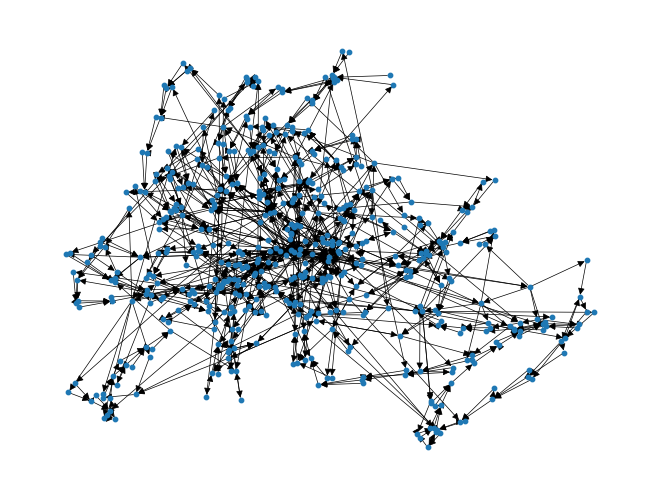

In [53]:
# Note. Slow cell :(
import networkx as nx

G = env.observation['Programl']
nx.draw(G, width=0.5, node_size=10)

In [54]:
env.observation['ProgramlJson']

{'directed': True,
 'graph': {'function': [{'module': 0, 'name': 'updateCRC32'},
   {'module': 0, 'name': 'crc32file'},
   {'module': 0, 'name': 'llvm.lifetime.start.p0i8'},
   {'module': 0, 'name': 'fopen'},
   {'module': 0, 'name': 'perror'},
   {'module': 0, 'name': 'getc'},
   {'module': 0, 'name': 'ferror'},
   {'module': 0, 'name': 'fclose'},
   {'module': 0, 'name': 'llvm.lifetime.end.p0i8'},
   {'module': 0, 'name': 'crc32buf'},
   {'module': 0, 'name': 'main1'},
   {'module': 0, 'name': 'printf'},
   {'module': 0, 'name': 'main'},
   {'module': 0, 'name': 'fprintf'},
   {'module': 0, 'name': '__isoc99_fscanf'}],
  'module': [{'features': {'llvm_data_layout': ['e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128'],
     'llvm_target_triple': ['x86_64-unknown-linux-gnu']},
    'name': '-'}]},
 'links': [{'flow': 0, 'key': 0, 'position': 0, 'source': 1, 'target': 2},
  {'flow': 0, 'key': 0, 'position': 0, 'source': 2, 'target': 3},
  {'flow': 1, 'key': 0, 'posi

In [55]:
env.observation['CpuInfo']

{'cores_count': 6,
 'l1d_cache_count': 6,
 'l1d_cache_size': 32768,
 'l1i_cache_count': 6,
 'l1i_cache_size': 32768,
 'l2_cache_count': 6,
 'l2_cache_size': 262144,
 'l3_cache_count': 1,
 'l3_cache_size': 12582912,
 'l4_cache_count': 0,
 'l4_cache_size': -1,
 'name': 'Intel Core i7-9750H'}

In [56]:
env.observation['IrInstructionCount']

242

In [57]:
env.observation['IrInstructionCountO0']

242

In [58]:
env.observation['IrInstructionCountO3']

164

In [59]:
env.observation['IrInstructionCountOz']

114

In [60]:
env.observation['ObjectTextSizeBytes']

1183

In [61]:
env.observation['ObjectTextSizeO0']

1183

In [62]:
env.observation['ObjectTextSizeO3']

3961

In [63]:
env.observation['ObjectTextSizeOz']

3286

In [64]:
env.observation['TextSizeBytes']

2747

In [65]:
env.observation['TextSizeO0']

2747

In [66]:
env.observation['TextSizeO3']

5539

In [67]:
env.observation['TextSizeOz']

4868

In [68]:
env.observation['IsBuildable']

True

In [69]:
env.observation['IsRunnable']

True

In [70]:
env.observation['Runtime']

array([0.003783])

In [71]:
env.observation['Buildtime']

array([0.045729])

In [73]:
env.observation['LexedIr'] # If doesn't work, it is available in newer version of CompilerGym, but better don't try to update our CompilerGym...

{'token_value': array(['', '', '-', ..., '', '', ''], dtype=object),
 'token_category': array(['keyword', 'keyword', 'strval', ..., 'type', 'apsint', 'keyword'],
       dtype=object),
 'token_id': array([ 63,   3, 400, ..., 413, 415,   9]),
 'token_kind': array(['kw_source_filename', 'equal', 'StringConstant', ..., 'Type',
        'APSInt', 'rbrace'], dtype=object)}

In [83]:
env.observation['Inst2vecPreprocessedText']

['opaque = type opaque',
 'opaque = type opaque',
 'opaque = type opaque',
 '<@ID> = internal global [256 x i64] [i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <INT>, i64 <I

In [84]:
env.observation['Inst2vecEmbeddingIndices']

[8564,
 8564,
 8564,
 8564,
 5,
 46,
 46,
 40,
 8564,
 13,
 8,
 8564,
 1348,
 178,
 286,
 214,
 182,
 235,
 697,
 1513,
 192,
 8564,
 182,
 182,
 395,
 1513,
 2298,
 8564,
 289,
 291,
 3729,
 3729,
 8564,
 178,
 289,
 289,
 200,
 1412,
 1412,
 8564,
 3032,
 180,
 3032,
 293,
 3032,
 205,
 415,
 205,
 213,
 8564,
 8564,
 8564,
 204,
 8564,
 213,
 215,
 364,
 364,
 216,
 8564,
 216,
 8564,
 8564,
 8564,
 311,
 634,
 204,
 8564,
 415,
 182,
 640,
 214,
 182,
 295,
 675,
 697,
 1513,
 192,
 8564,
 182,
 182,
 395,
 1513,
 214,
 216,
 8564,
 8564,
 8564,
 634,
 204,
 8564,
 213,
 215,
 415,
 205,
 216,
 8564,
 8564,
 8564,
 182,
 961,
 214,
 415,
 214,
 364,
 364,
 216,
 8564,
 293,
 3032,
 180,
 3032,
 8564,
 3032,
 295,
 257,
 8564,
 291,
 178,
 178,
 200,
 214,
 180,
 3032,
 205,
 216,
 8564,
 182,
 977,
 204,
 8564,
 182,
 213,
 235,
 697,
 1513,
 192,
 8564,
 182,
 182,
 395,
 1513,
 214,
 216,
 8564,
 182,
 420,
 214,
 213,
 8564,
 200,
 216,
 8564,
 182,
 961,
 180,
 3032,
 2298,
 85

In [85]:
env.observation['Inst2vec']

array([[-0.59749085,  0.63315004, -0.0308373 , ...,  0.14833118,
         0.86420786,  0.44808227],
       [-0.59749085,  0.63315004, -0.0308373 , ...,  0.14833118,
         0.86420786,  0.44808227],
       [-0.59749085,  0.63315004, -0.0308373 , ...,  0.14833118,
         0.86420786,  0.44808227],
       ...,
       [-0.8005934 ,  1.066408  , -0.94866973, ...,  0.65057874,
         0.07959317,  0.25205553],
       [-0.5932641 ,  0.55792844,  0.01643612, ...,  0.31370804,
         0.5398467 ,  0.64350367],
       [-0.61786747,  0.84928125, -0.19026336, ..., -0.2501209 ,
         0.2700288 ,  0.6338952 ]], dtype=float32)

In [86]:
env.observation['InstCountDict']

{'TotalInstsCount': 242,
 'TotalBlocksCount': 29,
 'TotalFuncsCount': 15,
 'RetCount': 5,
 'BrCount': 24,
 'SwitchCount': 0,
 'IndirectBrCount': 0,
 'InvokeCount': 0,
 'ResumeCount': 0,
 'UnreachableCount': 0,
 'CleanupRetCount': 0,
 'CatchRetCount': 0,
 'CatchSwitchCount': 0,
 'CallBrCount': 0,
 'FNegCount': 0,
 'AddCount': 5,
 'FAddCount': 0,
 'SubCount': 0,
 'FSubCount': 0,
 'MulCount': 0,
 'FMulCount': 0,
 'UDivCount': 0,
 'SDivCount': 0,
 'FDivCount': 0,
 'URemCount': 0,
 'SRemCount': 0,
 'FRemCount': 0,
 'ShlCount': 0,
 'LShrCount': 3,
 'AShrCount': 0,
 'AndCount': 3,
 'OrCount': 1,
 'XorCount': 8,
 'AllocaCount': 26,
 'LoadCount': 51,
 'StoreCount': 42,
 'GetElementPtrCount': 5,
 'FenceCount': 0,
 'AtomicCmpXchgCount': 0,
 'AtomicRMWCount': 0,
 'TruncCount': 1,
 'ZExtCount': 5,
 'SExtCount': 0,
 'FPToUICount': 0,
 'FPToSICount': 0,
 'UIToFPCount': 0,
 'SIToFPCount': 0,
 'FPTruncCount': 0,
 'FPExtCount': 0,
 'PtrToIntCount': 0,
 'IntToPtrCount': 0,
 'BitCastCount': 20,
 'AddrSpac

In [87]:
env.observation['InstCountNorm']

array([0.11983471, 0.06198347, 0.02066116, 0.09917355, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02066116,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01239669, 0.        , 0.01239669,
       0.00413223, 0.03305785, 0.10743801, 0.2107438 , 0.17355372,
       0.02066116, 0.        , 0.        , 0.        , 0.00413223,
       0.02066116, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08264463, 0.        , 0.        , 0.        , 0.04132231,
       0.        , 0.        , 0.13636364, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)

In [88]:
env.observation['InstCountNormDict']

{'TotalBlocksDensity': 0.11983471,
 'TotalFuncsDensity': 0.06198347,
 'RetDensity': 0.020661157,
 'BrDensity': 0.09917355,
 'SwitchDensity': 0.0,
 'IndirectBrDensity': 0.0,
 'InvokeDensity': 0.0,
 'ResumeDensity': 0.0,
 'UnreachableDensity': 0.0,
 'CleanupRetDensity': 0.0,
 'CatchRetDensity': 0.0,
 'CatchSwitchDensity': 0.0,
 'CallBrDensity': 0.0,
 'FNegDensity': 0.0,
 'AddDensity': 0.020661157,
 'FAddDensity': 0.0,
 'SubDensity': 0.0,
 'FSubDensity': 0.0,
 'MulDensity': 0.0,
 'FMulDensity': 0.0,
 'UDivDensity': 0.0,
 'SDivDensity': 0.0,
 'FDivDensity': 0.0,
 'URemDensity': 0.0,
 'SRemDensity': 0.0,
 'FRemDensity': 0.0,
 'ShlDensity': 0.0,
 'LShrDensity': 0.012396694,
 'AShrDensity': 0.0,
 'AndDensity': 0.012396694,
 'OrDensity': 0.004132231,
 'XorDensity': 0.03305785,
 'AllocaDensity': 0.10743801,
 'LoadDensity': 0.2107438,
 'StoreDensity': 0.17355372,
 'GetElementPtrDensity': 0.020661157,
 'FenceDensity': 0.0,
 'AtomicCmpXchgDensity': 0.0,
 'AtomicRMWDensity': 0.0,
 'TruncDensity': 0

In [89]:
env.observation['AutophaseDict']

{'BBNumArgsHi': 0,
 'BBNumArgsLo': 0,
 'onePred': 16,
 'onePredOneSuc': 12,
 'onePredTwoSuc': 2,
 'oneSuccessor': 16,
 'twoPred': 8,
 'twoPredOneSuc': 2,
 'twoEach': 4,
 'twoSuccessor': 8,
 'morePreds': 0,
 'BB03Phi': 0,
 'BBHiPhi': 0,
 'BBNoPhi': 29,
 'BeginPhi': 0,
 'BranchCount': 24,
 'returnInt': 9,
 'CriticalCount': 2,
 'NumEdges': 32,
 'const32Bit': 44,
 'const64Bit': 41,
 'numConstZeroes': 14,
 'numConstOnes': 36,
 'UncondBranches': 16,
 'binaryConstArg': 13,
 'NumAShrInst': 0,
 'NumAddInst': 5,
 'NumAllocaInst': 26,
 'NumAndInst': 3,
 'BlockMid': 5,
 'BlockLow': 24,
 'NumBitCastInst': 20,
 'NumBrInst': 24,
 'NumCallInst': 33,
 'NumGetElementPtrInst': 5,
 'NumICmpInst': 10,
 'NumLShrInst': 3,
 'NumLoadInst': 51,
 'NumMulInst': 0,
 'NumOrInst': 1,
 'NumPHIInst': 0,
 'NumRetInst': 5,
 'NumSExtInst': 0,
 'NumSelectInst': 0,
 'NumShlInst': 0,
 'NumStoreInst': 42,
 'NumSubInst': 0,
 'NumTruncInst': 1,
 'NumXorInst': 8,
 'NumZExtInst': 5,
 'TotalBlocks': 29,
 'TotalInsts': 242,
 'Tota

In [90]:
env.observation['LexedIrTuple'] # If doesn't work, it is available in newer version of CompilerGym, but better don't try to update our CompilerGym...

[LexedToken(ID=63, kind='kw_source_filename', category='keyword', value=''),
 LexedToken(ID=3, kind='equal', category='keyword', value=''),
 LexedToken(ID=400, kind='StringConstant', category='strval', value='-'),
 LexedToken(ID=61, kind='kw_target', category='keyword', value=''),
 LexedToken(ID=66, kind='kw_datalayout', category='keyword', value=''),
 LexedToken(ID=3, kind='equal', category='keyword', value=''),
 LexedToken(ID=400, kind='StringConstant', category='strval', value='e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128'),
 LexedToken(ID=61, kind='kw_target', category='keyword', value=''),
 LexedToken(ID=62, kind='kw_triple', category='keyword', value=''),
 LexedToken(ID=3, kind='equal', category='keyword', value=''),
 LexedToken(ID=400, kind='StringConstant', category='strval', value='x86_64-unknown-linux-gnu'),
 LexedToken(ID=398, kind='LocalVar', category='strval', value='struct._IO_FILE'),
 LexedToken(ID=3, kind='equal', category='keyword', value=''),

So we have observed all possible varians of observations. 

#### Setup observation space

Choose one of them for setup!

In [92]:
# Why do we need setup? Look:
env.reset()
observation, reward, done, info = env.step(9)

print(f"Current observation is observation={observation}")

Current observation is observation=None


To fix this `None` we should setup observation.

**Variant 1.** Use already prepared env from ``compiler_gym.COMPILER_GYM_ENVS``


In [93]:
compiler_gym.COMPILER_GYM_ENVS

['gcc-v0',
 'llvm-v0',
 'llvm-ic-v0',
 'llvm-codesize-v0',
 'llvm-autophase-ic-v0',
 'llvm-autophase-codesize-v0',
 'llvm-ir-ic-v0',
 'llvm-ir-codesize-v0',
 'loop_tool-v0']

In [95]:
env.close()
env = compiler_gym.make("llvm-autophase-ic-v0")
observation = env.reset()
print(f"Initial observation is observation={observation}")

Initial observation is observation=[  0   4  54  39  12  46  23   6  12  31   2   4   0  81   4  77  13  15
 108 106  75  51  71  46  15   0   9  46   0  13  72  51  77  81  39  31
   0 163   2   0   4   6  13   1   0  73   8   1   0  15  85 638 402  16
  10 298]


**Variant 2.** Be more descriptive in `compiler_gym.make(...)`

In [96]:
env.close()
env = compiler_gym.make(
    "llvm-v0",                              # selects the compiler to use
    benchmark="cbench-v1/qsort",            # selects the program to compile
    observation_space="Autophase",          # selects the observation space
    reward_space="IrInstructionCountOz",    # selects the reward space
)
observation = env.reset()
print(f"Initial observation is observation={observation}")

Initial observation is [  0   4  54  39  12  46  23   6  12  31   2   4   0  81   4  77  13  15
 108 106  75  51  71  46  15   0   9  46   0  13  72  51  77  81  39  31
   0 163   2   0   4   6  13   1   0  73   8   1   0  15  85 638 402  16
  10 298]


**Variant 3\***. If the ready-to-use list of observation is just not enough for you. Prepare your own observation wrapper

`compiler_gym.wrappers.ObservationWrapper`

In [97]:
help(compiler_gym.wrappers.ObservationWrapper)

Help on class ObservationWrapper in module compiler_gym.wrappers.core:

class ObservationWrapper(CompilerEnvWrapper, abc.ABC)
 |  ObservationWrapper(env: compiler_gym.envs.compiler_env.CompilerEnv)
 |  
 |  Wraps a :class:`CompilerEnv <compiler_gym.envs.CompilerEnv>` environment
 |  to allow an observation space transformation.
 |  
 |  Method resolution order:
 |      ObservationWrapper
 |      CompilerEnvWrapper
 |      compiler_gym.envs.compiler_env.CompilerEnv
 |      gym.core.Wrapper
 |      gym.core.Env
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  convert_observation(self, observation: ~ObservationType) -> ~ObservationType
 |      Translate an observation to the new space.
 |  
 |  multistep(self, actions: List[~ActionType], observation_spaces: Optional[Iterable[Union[str, compiler_gym.views.observation_space_spec.ObservationSpaceSpec]]] = None, reward_spaces: Optional[Iterable[Union[str, compiler_gym.spaces.reward.Reward]]] = None, observations

In [103]:
env.close()

Let's finish our exploration of environment here and process to the task! 🏃

## Task

The task is to try to solve some of Compiler Gym environments:
1. Setup the problem you are going to solve
2. Test your environment on StableBaselines black-box algorithms
3. Implement your own solution (DQN, DQN with ER, Actor-Critic)

Note. Succesful solution can be published in open-source compiler gym leaderbord!

Note. If you have some problems, restart the kernel and execute everything again! Or ask Albina for help)

### Imports

In [104]:
import random
import statistics
from collections import namedtuple
from typing import List

import compiler_gym
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from absl import app, flags
from torch.distributions import Categorical

In [105]:
# seeding
# SEED = ...
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Setup environment

#### Initialize environment

Prepare simple initialization of enviroment with params of env name, observation space, reward space and benchmark.

In [108]:
ENV_NAME = "llvm-v0"
OBSERVATION_SPACE = "Autophase"
REWARD_SPACE = "IrInstructionCountOz" ## Success Threshold: 1.0
BENCHMARK = "cbench-v1/qsort"

In [109]:
from compiler_gym.envs.llvm.llvm_env import LlvmEnv

def init_env(
    env_name: str, 
    observation_space: str, 
    reward_space: str, 
    benchmark: str
    ) -> LlvmEnv:
    """Initialize the environment with provided parameters

    Args:
        env_name (str): Name of the environment
        observation_space (str): Name of the observation space
        reward_space (str): Name of the reward space
        benchmark (str): Name of the benchmark

    Returns:
        LlvmEnv: ready to use ComlerGym environment
    """

    # env = ...  # Your code here
    env = compiler_gym.make(
        env_name,
        observation_space=observation_space,
        reward_space=reward_space,
        benchmark=benchmark,
    )
    return env

In [111]:
env = init_env(ENV_NAME, OBSERVATION_SPACE, REWARD_SPACE, BENCHMARK)

assert env.observation_space_spec.id == OBSERVATION_SPACE
assert env.reward_space == REWARD_SPACE
assert env.benchmark.uri.dataset in BENCHMARK
assert env.benchmark.uri.path in BENCHMARK
assert env.benchmark.uri.fragment in BENCHMARK

#### Prepare some observation wrapper



In [112]:
class MyObs(gym.ObservationWrapper):
    """May be lower observation space somehow
    """

    def __init__(self, env):
        super().__init__(env=env)
        self.observation_space = gym.spaces.Box(...)

    def reset(self, *args, **kwargs):
        return super().reset(*args, **kwargs)

    def step(self, action: int):
        return super().step(action)

    def observation(self, observation):
        # Here you can transform observation
        return observation

In [113]:
class HistoryObservation(gym.ObservationWrapper):
    """For the input representation (state), if there are N possible
    actions, then an action x is represented by a one-hot vector V(x)
    with N entries. A sequence of M actions (x, y, ...) is represented
    by an MxN matrix of 1-hot vectors (V(x), V(y), ...). Actions that
    have not been taken yet are represented as the zero vector. This
    way the input does not have a variable size since each episode has
    a fixed number of actions.
    """

    def __init__(self, env: LlvmEnv, max_episode_len: int):
        super().__init__(env=env)
        
        self.max_episode_len = max_episode_len
        
        self.observation_space = gym.spaces.Box(
            low=0, high=1,
            shape=((self.max_episode_len - 1) * self.action_space.n,),
            dtype=np.int32,
        )

    def reset(self, *args, **kwargs):
        self._steps_taken = 0
        self._state = np.zeros(
            (self.max_episode_len - 1, self.action_space.n), dtype=np.int32
        )
        return super().reset(*args, **kwargs)

    def step(self, action: int):

        assert self._steps_taken < self.max_episode_len

        if self._steps_taken < self.max_episode_len - 1:
            # Don't need to record the last action since there are no
            # further decisions to be made at that point, so that
            # information need never be presented to the model.
            self._state[self._steps_taken][action] = 1

        self._steps_taken += 1
        return super().step(action)

    def observation(self, observation):
        return self._state.flatten()

#### Add wrappers

Define initial params to wrappers to limit the action space and the episode length and add all wrappers to your env

In [114]:
# List of optimizatins to explore
# TODO check what optimization are in Oz, O3, ...
FLAGS = [
    "-break-crit-edges",
    "-early-cse-memssa",
    "-gvn-hoist",
    "-gvn",
    "-instcombine",
    "-instsimplify",
    "-jump-threading",
    "-loop-reduce",
    "-loop-rotate",
    "-loop-versioning",
    "-mem2reg",
    "-newgvn",
    "-reg2mem",
    "-simplifycfg",
    "-sroa",
]

EPISODE_LEN = 10  # Number of transitions per episode

In [115]:
from compiler_gym.wrappers import ConstrainedCommandline, TimeLimit

def wrap_env(env):
    # env = ...
    env = ConstrainedCommandline(env, FLAGS)
    env = TimeLimit(env, EPISODE_LEN)
    # env = HistoryObservation(env, EPISODE_LEN)
    return env

In [118]:
env = wrap_env(env)

assert set(env.action_space.flags) == set(FLAGS)
env.reset()
dones = []
for i in range(EPISODE_LEN):
    _, _, done, _ = env.step(env.action_space.sample())
    dones.append(done)
assert dones == [False] * (len(dones) - 1) + [True]

### Stable baselines

[Stable Baselines3 (SB3)](https://stable-baselines3.readthedocs.io/en/master/) is a set of reliable implementations of reinforcement learning algorithms in PyTorch. Algorithms here are clean, safe and sound. 

These implementations can be used to verify your environment on first stages and further become a baseline for your SOTA solution. Let's utilize stable baselines for CompilerGym environment!

#### 1. Formal check of environment

This check can catch errors that make your environment incompatible with SB3 algorithms. For examlple, if your defined observation or action space is not compatible with actual type and dimensions of actions and observations. 

In [119]:
from stable_baselines3.common.env_checker import check_env

# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

#### 2. Tensorboard

To visualize the training process we are going to use tensorboard (which is automatically added to SB3 algorithms)

You can use tensorboard in a notebook cell (not recommended) or review the local server in your browser (recommended).

To enable tensorboard logging define folder to store your tensorboard logs ``LOGS_BASE_DIR`` during SB3 model initialization:

```python
from stable_baselines3 import PPO

model = PPO(
    policy = ...,
    env = ...,
    tensorboard_log="./LOGS_BASE_DIR/")
``` 

* to use tensorboard from notebook:

    1. Load IPython tensorboard extension ``%load_ext tensorboard``
    2. Prepare a cell for server ``%tensorboard --logdir LOGS_BASE_DIR``. Logs will be read from the folder ``LOGS_BASE_DIR``.

* to start local server:

    1. Run tensorboard server in terminal: ``tensorboard --logdir LOGS_BASE_DIR``
    2. Follow the link [`` http://localhost:6006/ ``]( http://localhost:6006/ ) in browser.

In [13]:
import os

logs_base_dir = "./logs" 
os.makedirs(logs_base_dir, exist_ok=True)

In [121]:
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

In [122]:
# Define a PPO MLpPolicy architecture
model = PPO(policy = 'MlpPolicy',
    env = env,
    n_steps = 2048,
    batch_size = 64,
    n_epochs = 10,
    gamma = 0.9,
    gae_lambda = 0.98,
    verbose=1, 
    tensorboard_log="./logs/",
    device='cpu')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


You can use `TensorboardCallback` to add more logging entities.
```python
from stable_baselines3.common.callbacks import BaseCallback

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        # Log scalar value (here a random variable)
        value = np.random.random()
        self.logger.record("random_value", value)
        return True

...
model.learn(..., callback=TensorboardCallback()) #MlpPolic
```

#### 3. Start training

To explore the meaning of logger metrics follow [the link](https://stable-baselines3.readthedocs.io/en/master/common/logger.html#explanation-of-logger-output)

In [17]:
# Train the agent
model.learn(200_000)

Logging to ./logs/PPO_7
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 0.397    |
| time/              |          |
|    fps             | 397      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 0.778       |
| time/                   |             |
|    fps                  | 368         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014389098 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.7        |
|    explained_variance   | -0.198      |
|    l

KeyboardInterrupt: 

#### 4. Save model (the good one)

In [20]:
model.save("./saved_models/PPO_Model.zip")

/home/cinemere/anaconda3/envs/compiler_gym/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:278: UserWarning: Path 'saved_models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [123]:
# To load model use:
model = PPO.load("./saved_models/PPO_Model.zip", env=env, device="cpu")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


#### 5. Review the predictions

In [130]:
print("Learned model predictions:")
obs = env.reset()
done = False
overall_reward = 0

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action.item())
    overall_reward += reward
    
print(f"Taken actions: {env.commandline()}")
print(f"Encoded actions: {env.commandline_to_actions(env.commandline())}")
print(f"Received reward: {overall_reward}")

Learned model predictions:
Taken actions: opt -sroa -early-cse-memssa -newgvn -gvn -jump-threading -simplifycfg -gvn -mem2reg -gvn -instcombine input.bc -o output.bc
Encoded actions: [111, 29, 97, 39, 55, 10, 39, 103, 39, 53]
Received reward: 1.1207430340557276


In [128]:
print("Random agent predictions:")
obs = env.reset()
done = False
overall_reward = 0

while not done:
    obs, reward, done, _ = env.step(env.action_space.sample())
    overall_reward += reward
    
print(f"Taken actions: {env.commandline()}")
print(f"Encoded actions: {env.commandline_to_actions(env.commandline())}")
print(f"Received reward: {overall_reward}")

Random agent predictions:
Taken actions: opt -early-cse-memssa -jump-threading -loop-versioning -reg2mem -loop-reduce -reg2mem -loop-versioning -jump-threading -early-cse-memssa -loop-versioning input.bc -o output.bc
Encoded actions: [29, 55, 81, 27, 75, 27, 81, 55, 29, 81]
Received reward: 0.2662538699690402


### DQN

Now let's prepare your own algorithm. We will try DQN!

DQN — an approximate Q-learning algorithm with experience replay and target networks — and see if it works any better this way.

Original paper: https://arxiv.org/pdf/1312.5602.pdf

To approximate the Q-function of agent, we are going to minimize TD-error:
$$\delta = Q_{\theta}(s, a) - [r(s, a) + \gamma \cdot max_{a'} Q_{-}(s', a')]$$
$$L = \frac{1}{N} \sum_i \delta_i^2,$$

where
* $a$ — action, $r$ — reward, $s$ — current state, $s'$ — next state,
* $\gamma$ — discountion factor.

$Q_{\theta}$ — Q-function with backprop, $Q_{-}$ — Q-function without backprop.

#### 1. Prepare network

We will use combination of linear layers and activations.
* linear layers: ``torch.nn.Linear(input_dim, output_dim)``
* relu activation: ``torch.nn.ReLU()``
* tanh activation: ``torch.nn.Tanh()``

To learn more about building neural networks in pytorch follow [the link](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

Hint!
Collect list of layers in ``layers`` variable.
Use ``nn.Sequential(*layers)`` to combine layers.

In [155]:
import torch
import torch.nn as nn

def create_network(input_dim: int, hidden_dims: List[int], output_dim: int):
    # network = nn.Sequential(
    #    torch.nn.Linear(input_dim, ...),
    #    torch.nn.ReLU() or Tanh(),
    #    ...
    # )
    ####### Здесь ваш код ########
    from_dim = input_dim
    layers = []
    for to_dim in hidden_dims:
        layers.extend([
            nn.Linear(from_dim, to_dim),
            nn.Tanh()
        ])
        from_dim = to_dim

    layers.append(nn.Linear(from_dim, output_dim))
    network = nn.Sequential(*layers)
    ##############################
    return network

In [156]:
hidden_dims = (64, 64)
Q = create_network(
    input_dim = env.observation_space.shape[0], 
    hidden_dims = hidden_dims, 
    output_dim = env.action_space.n
)
assert Q._modules['0'].in_features == env.observation_space.shape[0]
keys = list(Q._modules.keys())
assert len(keys) + 1 == (len(hidden_dims) + 1) * 2
assert all([isinstance(Q._modules[layer], nn.Linear) for layer in keys[::2]])

#### 2. Epsilon-greedy action selection

The easiest scheme to have some trade-off between expotration and exploitation is *epsilon-greedy* strategy.

Select random action with $\epsilon$ probability and greedy action (model prediction) with probability $(1 - \epsilon)$.

Note. Our model is a `Q-function` which returns probabilities for the best action in current state. To perform greedy action, choose the action with `max` predicted probability.

In [157]:
def select_action_eps_greedy(Q, state, epsilon):
    """Select action epsilon-greedy."""
    if not isinstance(state, torch.Tensor):
        state = torch.tensor(state, dtype=torch.float32)
    Q_s = Q(state).detach().numpy()

    # action =
    ####### Your code ########
    if np.random.random() < epsilon:
        n_actions = Q_s.shape[-1]
        action = np.random.choice(n_actions)
    else:
        action = np.argmax(Q_s)
    ##############################

    action = int(action)
    return action

#### 3. Compute TD-loss

TD is temporal difference.

Let's add utility function to transform any list to float tensor (torch works with tensors).

In [158]:
def to_tensor(x, dtype=np.float32):
    if isinstance(x, torch.Tensor):
        return x
    x = np.asarray(x, dtype=dtype)
    x = torch.from_numpy(x)
    return x

In [159]:
# s = test_env.reset()
# s = to_tensor(s)              # shape: [batch_size, state_size]
# a = torch.tensor([2, 1, 0])
# s_batch = torch.concat([s, s, s]).view(3, -1)
# Q(s_batch)[torch.arange(3), a]
# torch.unsqueeze(a, 1)
# torch.gather(Q(s_batch), dim=1, index=torch.unsqueeze(a, 1)).squeeze(-1)

Optimal value-function: $V^*(s) = \max_{a} Q(s, a)$

TD-target: $Q_{target}(s, a, s') = r(s, a) + \gamma \cdot max_{a'} Q_{-}(s', a')$

TD-error: $Q_{\theta}(s, a) - Q_{target}(s, a, s')$

For better generalization we will use batches here.

In [160]:
def compute_td_loss(
        Q, states, actions, rewards, next_states, terminateds,
        gamma=0.99, check_shapes=False, regularizer=.1
):
    """Compute TD error."""

    # transform input data to tensors
    s = to_tensor(states)              # shape: [batch_size, state_size]
    a = to_tensor(actions, int).long()        # shape: [batch_size]
    r = to_tensor(rewards)                    # shape: [batch_size]
    s_next = to_tensor(next_states)           # shape: [batch_size, state_size]
    term = to_tensor(terminateds, bool)       # shape: [batch_size]

    # Receive Q_theta[s, a] for each selected action in current state (for each element in batch)
    # Q_s_a = ...
    ####### Your code ########
    # Q_s_a = torch.gather(Q(s), dim=1, index=torch.unsqueeze(a, 1)).squeeze(-1)
    Q_s_a = Q(s)[torch.arange(s.shape[0]), a]
    ##############################

    # Receive optimal values of quality at next states:
    # 1. Receive Q_{-}[s_next, *] — quality of each action for all next states in batch
    # Q_sn = ...,
    # 2. Obtain max_{a'} Q_{-}[s_next, a'] or V*[s_next] — optimal qualities of next states
    # V_sn = ...
    # Note. Don't forget to stop gradents from evaluation here.
    ####### Your code ########
    with torch.no_grad():
        Q_sn = Q(s_next)
        V_sn, _ = torch.max(Q_sn, axis=-1)
    ##############################

    assert V_sn.dtype == torch.float32

    # Estimate TD-target and TD-error
    # target = ...
    # td_error = ...
    # Note. Don't forget to omit termination steps.
    ####### Your code ########
    target = r + gamma * V_sn * torch.logical_not(term)
    td_error = Q_s_a - target
    ##############################

    # Use MSE loss to minimize TD-error
    loss = torch.mean(td_error ** 2)
    # Add regularization on Q
    loss += regularizer * Q_s_a.mean()

    if check_shapes:
        assert Q_sn.data.dim(
        ) == 2, "Check that you have predicted q-values for all actions in the next state"
        assert V_sn.data.dim(
        ) == 1, "Check that you have estimated V (s ') as maximum only over actions dimension (not over all dimensions)"
        assert target.data.dim(
        ) == 1, "Something is wrong with target q-values, they should be a vector"

    return loss

#### 4. Training

In [161]:
def eval_one_episode(env, Q):
    """Evaluate the quality of your algorithm on one episode."""
    s = env.reset()
    done, ep_return = False, 0.

    while not done:
        # set epsilon = 0 to make an agent act greedy
        a = select_action_eps_greedy(Q, s, epsilon=0.)
        s_next, r, done, _ = env.step(a)
        ep_return += r
        s = s_next

        if done:
            break
        
    env.reset()
    return ep_return

In [169]:
from collections import deque
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


def linear(st, end, duration, t):
    """Linear scheduling of epsilon-greedy strategy"""
    if t >= duration:
        return end
    return st + (end - st) * (t / duration)

def run_dqn(
        env,
        hidden_dims=(128, 128), lr=1e-3,
        eps_st=.4, eps_end=.02, eps_dur=.5, total_max_steps=100_000,
        train_schedule=4, eval_schedule=50, smooth_ret_window=5, success_ret=1.
):
    """Learn DQN agent.

    Args:
        env (gym.Env): environment.
        hidden_dims (tuple, optional): hidden dimesions of Q-network. Defaults to (128, 128).
        lr (_type_, optional): learning rate. Defaults to 1e-3.
        eps_st (float, optional): starting epsilon value in epsilon-greedy strategy. Defaults to .4.
        eps_end (float, optional): final epsilon value in epsilon-greedy strategy. Defaults to .02.
        eps_dur (float, optional): duration for scaling of linear epsilon-greedy strategy. Defaults to .5.
        total_max_steps (_type_, optional): overall number of learning steps in environment. Defaults to 100_000.
        train_schedule (int, optional): frequency of training update (same as batch size). Defaults to 4.
        eval_schedule (int, optional): frequency of evaluation. Defaults to 50.
        smooth_ret_window (int, optional): number of windows to smooth the evaluation return. Defaults to 5.
        success_ret (_type_, optional): stopping criteria of learning (max reward we want to reach). Defaults to 1..
    """
    now = datetime.now().strftime('%m-%d-%y--%H-%M-%S')
    writer = SummaryWriter(f"./logs/DQN_{now}")

    eval_return_history = deque(maxlen=smooth_ret_window)
    buffer = deque(maxlen=train_schedule)

    Q = create_network(
        input_dim=env.observation_space.shape[0], hidden_dims=hidden_dims, output_dim=env.action_space.n
    )
    opt = torch.optim.Adam(Q.parameters(), lr=lr)

    s = env.reset()
    done = False
    train_episodes = 0

    for global_step in range(1, total_max_steps+1):
        epsilon = linear(eps_st, eps_end, eps_dur * total_max_steps, global_step)
        a = select_action_eps_greedy(Q, s, epsilon=epsilon)
        s_next, r, done, _ = env.step(a)
        
        buffer.append((s, a, r, s_next, done))
        
        if global_step % train_schedule == 0:
            opt.zero_grad()
            batch = tuple([list(elem) for elem in zip(*list(buffer))])
            loss = compute_td_loss(Q, *batch)
            loss.backward()
            opt.step()

        s = s_next
        if done:
            s = env.reset()
            done = False
            train_episodes += 1

            if train_episodes % eval_schedule == 0:
                with torch.no_grad():
                    eval_return = eval_one_episode(env, Q)
                eval_return_history.append(eval_return)
                avg_return = np.mean(eval_return_history)
                print(f'global_step={global_step} | avg_return={avg_return:.3f} | epsilon={epsilon:.3f}')
                writer.add_scalar("Eval/avg_return", avg_return, global_step)
                writer.add_scalar("Eval/epsilon", epsilon, global_step)
                if avg_return >= success_ret:
                    print('Solved!')
                    break


In [170]:
env

<TimeLimit<ConstrainedCommandline<LlvmEnv<llvm-v0>>>>

In [173]:
run_dqn(env)

global_step=500 | avg_return=0.904 | epsilon=0.396
global_step=1000 | avg_return=0.904 | epsilon=0.392
global_step=1500 | avg_return=0.949 | epsilon=0.389
global_step=2000 | avg_return=0.713 | epsilon=0.385
global_step=2500 | avg_return=0.751 | epsilon=0.381
global_step=3000 | avg_return=0.751 | epsilon=0.377
global_step=3500 | avg_return=0.528 | epsilon=0.373
global_step=4000 | avg_return=0.500 | epsilon=0.370
global_step=4500 | avg_return=0.697 | epsilon=0.366
global_step=5000 | avg_return=0.697 | epsilon=0.362
global_step=5500 | avg_return=0.721 | epsilon=0.358
global_step=6000 | avg_return=0.776 | epsilon=0.354
global_step=6500 | avg_return=0.776 | epsilon=0.351
global_step=7000 | avg_return=0.776 | epsilon=0.347
global_step=7500 | avg_return=0.803 | epsilon=0.343
global_step=8000 | avg_return=0.599 | epsilon=0.339
global_step=8500 | avg_return=0.768 | epsilon=0.335
global_step=9000 | avg_return=0.768 | epsilon=0.332
global_step=9500 | avg_return=0.652 | epsilon=0.328
global_step=1

KeyboardInterrupt: 

### DQN with Experience Replay

Now we are going to add memory to our agent which is represented as Experience Replay Buffer. 

The buffer will be used to keep utilized trajectories to memory and then training on randomly sampled events from it.

The buffer will be a ``deque`` with the following elements: $\{(s, a, r, s', 1_{done})\}$ 

#### 1. Sample from ROB

Create a sample from buffer of fixed length.

[Hint](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html). Use ``np.random.choice()`` to define random indicies from buffer.

In [142]:
def sample_batch(replay_buffer, n_samples):
    # sample randomly `n_samples` samples from replay buffer
    # and split an array of samples into arrays: states, actions, rewards, next_actions, terminateds
    ####### Your code ########
    n_samples = min(len(replay_buffer), n_samples)

    indices = np.random.choice(len(replay_buffer), n_samples, replace=False)
    states, actions, rewards, next_actions, terminateds = [], [], [], [], []
    for i in indices:
        s, a, r, n_s, done = replay_buffer[i]
        states.append(s)
        actions.append(a)
        rewards.append(r)
        next_actions.append(n_s)
        terminateds.append(done)
    ##############################

    return np.array(states), np.array(actions), np.array(rewards), np.array(next_actions), np.array(terminateds)

#### 2. Training 

In [174]:
def run_dqn_rb(
        env,
        hidden_dims=(256, 256), lr=2e-3,
        eps_st=.4, eps_end=.02, eps_dur=.5, total_max_steps=200_000,
        train_schedule=4, replay_buffer_size=400, batch_size=16,
        eval_schedule=50, smooth_ret_window=5, success_ret=1.
):
    """Learn DQN with Experience Replay agent.

    Args:
        env (gym.Env): environment.
        hidden_dims (tuple, optional): hidden dimesions of Q-network. Defaults to (256, 256).
        lr (_type_, optional): learning rate. Defaults to 2e-3.
        eps_st (float, optional): starting epsilon value in epsilon-greedy strategy. Defaults to .4.
        eps_end (float, optional): final epsilon value in epsilon-greedy strategy. Defaults to .02.
        eps_dur (float, optional): duration for scaling of linear epsilon-greedy strategy. Defaults to .5.
        total_max_steps (_type_, optional): overall number of learning steps in environment. Defaults to 200_000.
        train_schedule (int, optional): frequency of training update (same as batch size). Defaults to 4.
        replay_buffer_size (int, optional): size of replay buffer. Defaults to 400.
        batch_size (int, optional): batch size (number of elements on which we update each time). Defaults to 16.
        eval_schedule (int, optional): frequency of evaluation. Defaults to 50.
        smooth_ret_window (int, optional): number of windows to smooth the evaluation return. Defaults to 5.
        success_ret (_type_, optional): stopping criteria of learning (max reward we want to reach). Defaults to 1..
    """
    now = datetime.now().strftime('%m-%d-%y--%H-%M-%S')
    writer = SummaryWriter(f"./logs/DQNwER_{now}")
    
    replay_buffer = deque(maxlen=replay_buffer_size)
    eval_return_history = deque(maxlen=smooth_ret_window)

    Q = create_network(
        input_dim=env.observation_space.shape[0], hidden_dims=hidden_dims, output_dim=env.action_space.n
    )
    opt = torch.optim.Adam(Q.parameters(), lr=lr)

    s = env.reset()
    done = False
    train_episodes = 0

    for global_step in range(1, total_max_steps+1):
        epsilon = linear(eps_st, eps_end, eps_dur * total_max_steps, global_step)
        a = select_action_eps_greedy(Q, s, epsilon=epsilon)
        s_next, r, done, _ = env.step(a)

        replay_buffer.append((s, a, r, s_next, done))
        
        if global_step % train_schedule == 0:
            train_batch = sample_batch(replay_buffer, batch_size)
            states, actions, rewards, next_states, terminateds = train_batch

            opt.zero_grad()
            loss = compute_td_loss(Q, states, actions, rewards, next_states, terminateds)
            loss.backward()
            opt.step()

        s = s_next
        if done:
            s = env.reset()
            done = False
            train_episodes += 1
            
            if train_episodes % eval_schedule == 0:
                eval_return = eval_one_episode(env, Q)
                eval_return_history.append(eval_return)
                avg_return = np.mean(eval_return_history)
                print(f'global_step={global_step} | avg_return={avg_return:.3f} | epsilon={epsilon:.3f}')
                writer.add_scalar("Eval/avg_return", avg_return, global_step)
                writer.add_scalar("Eval/epsilon", epsilon, global_step)
                if avg_return >= success_ret:
                    print('Solved!')
                    break


In [175]:
run_dqn_rb(env)

global_step=500 | avg_return=0.904 | epsilon=0.398
global_step=1000 | avg_return=0.454 | epsilon=0.396
global_step=1500 | avg_return=0.484 | epsilon=0.394
global_step=2000 | avg_return=0.351 | epsilon=0.392
global_step=2500 | avg_return=0.294 | epsilon=0.391
global_step=3000 | avg_return=0.114 | epsilon=0.389
global_step=3500 | avg_return=0.222 | epsilon=0.387
global_step=4000 | avg_return=0.100 | epsilon=0.385
global_step=4500 | avg_return=0.109 | epsilon=0.383
global_step=5000 | avg_return=0.205 | epsilon=0.381
global_step=5500 | avg_return=0.385 | epsilon=0.379
global_step=6000 | avg_return=0.289 | epsilon=0.377
global_step=6500 | avg_return=0.411 | epsilon=0.375
global_step=7000 | avg_return=0.426 | epsilon=0.373
global_step=7500 | avg_return=0.308 | epsilon=0.372
global_step=8000 | avg_return=0.128 | epsilon=0.370


KeyboardInterrupt: 

### Actor-Critic

Now let's try one of gradient methods for our task: [Actor-Critic](https://proceedings.neurips.cc/paper_files/paper/1999/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf). To learn more about gradient method follow [the link](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html).

Gradient of value function $Q^{\pi}(s, a)$ and gradient of policy $\pi$ are connected by the following equation:

$$\nabla_\theta J(\theta) = \mathbb{E}_\pi [Q^\pi(s, a) \nabla_\theta \ln \pi_\theta(a \vert s)]$$

How to evaluate $Q^\pi(s, a)$? Actor-Critic suggests to use separate critic NN.

#### 1. Prepare Actor-Critic Network

Our Actor-Critic network will have 2 parts: Actor and Critic. They would have common bodies but separate heads.

Actor: `input` $\rightarrow$ `net` $\rightarrow$ `actor_head` $\rightarrow$ `actor_output`\
Critic: `input` $\rightarrow$ `net` $\rightarrow$ `critic_head` $\rightarrow$ `critic_output`

In [145]:
import torch
import torch.nn as nn
from torch.distributions import Categorical

class ActorBatch:
    def __init__(self):
        self.logprobs = []
        self.q_values = []

    def append(self, log_prob, q_value):
        self.logprobs.append(log_prob)
        self.q_values.append(q_value)

    def clear(self):
        self.logprobs.clear()
        self.q_values.clear()

In [147]:
class ActorCriticModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()

        # Initialize ActorCritic net with 2 heads: softmax-actor and linear critic
        # self.net, self.actor_head, self.critic_head =
        ####### Your code ########
        from_dim = input_dim
        layers = []
        for to_dim in hidden_dims:
            layers.extend([
                nn.Linear(from_dim, to_dim),
                nn.Tanh()
            ])
            from_dim = to_dim

        self.net = nn.Sequential(*layers)
        self.actor_head = nn.Sequential(
            nn.Linear(hidden_dims[-1], output_dim),
            nn.Softmax(dim=-1)
        )
        self.critic_head = nn.Sequential(
            nn.Linear(hidden_dims[-1], output_dim),
        )
        # self.actor_head = nn.Sequential(
        #     create_network(input_dim, hidden_dims, output_dim),
        #     nn.Softmax(dim=-1)
        # )
        # self.critic_head = create_network(input_dim, hidden_dims, output_dim)
        ##############################

    def forward(self, state):
        # Estimate selected action, its log probability and Q-function value
        ####### Your code ########
        state = self.net(state)

        action_probs = self.actor_head(state)
        dist = Categorical(action_probs)
        action = dist.sample()

        q_values = self.critic_head(state)

        log_prob = dist.log_prob(action)
        action = action.item()
        # adv = q_values[action] - torch.sum(q_values * action_probs, -1)
        q_value = q_values[action]
        ##############################

        return action, log_prob, q_value

    def evaluate(self, state):
        # Return Q-value for a given state
        ####### Your code ########
        state = self.net(state)

        q_values = self.critic_head(state)
        ##############################
        return q_values

#### 2. Prepare update stratedy for actor and critic 

In [148]:
class ActorCriticAgent:
    def __init__(self, state_dim, action_dim, hidden_dims, lr, gamma, critic_rb_size):
        self.lr = lr
        self.gamma = gamma

        # Initialize ActorCriticModel and и SGD optimizer (например, `torch.optim.Adam)`)
        ####### Your code ########
        self.actor_critic = ActorCriticModel(state_dim, hidden_dims, action_dim)
        self.actor_opt = self.critic_opt = self.opt = torch.optim.Adam(self.actor_critic.parameters(), lr=lr)
        # self.actor_opt = torch.optim.Adam(self.actor_critic.actor_head.parameters(), lr=lr)
        # self.critic_opt = torch.optim.Adam(self.actor_critic.critic_head.parameters(), lr=lr*.25)
        ##############################

        self.actor_batch = ActorBatch()
        self.critic_rb = deque(maxlen=critic_rb_size)

    def act(self, state):
        # Select action and save logprob and q_value to batch (for further update)
        # Don't forget q_value.detach()
        # self.actor_batch.append(..)
        ####### Your code ########
        action, logprob, q_value = self.actor_critic(to_tensor(state))
        self.actor_batch.append(logprob, q_value.detach())

        # action = select_action_eps_greedy(self.actor_critic.critic_head, state, 0.05)
        ##############################

        return action

    def append_to_replay_buffer(self, s, a, r, next_s, terminated):
        # Add new trajectory item to critic's memomy.
        ####### Your code ########
        self.critic_rb.append((s, a, r, next_s, terminated))
        ##############################

    def evaluate(self, state):
        return self.actor_critic.evaluate(state)

    def update(self, rollout_size, critic_batch_size, critic_updates_per_actor):
        if len(self.actor_batch.q_values) < rollout_size:
            return

        self.update_actor()
        self.update_critic(critic_batch_size, critic_updates_per_actor)

    def update_actor(self):
        Q_s_a = to_tensor(self.actor_batch.q_values)
        logprobs = torch.stack(self.actor_batch.logprobs)

        # Update agent:
        # 0. (optional) Normalize returns
        # 1. Estimate loss
        # 2. Perform gradient step
        ####### Здесь ваш код ########
        # Нормализация отдач
        Q_s_a = (Q_s_a - Q_s_a.mean()) / (Q_s_a.std() + 1e-7)

        # Считаем ошибку
        loss = torch.mean(-logprobs * Q_s_a)

        self.actor_opt.zero_grad()
        loss.backward()
        self.actor_opt.step()
        self.actor_batch.clear()
        ##############################

    def update_critic(self, batch_size, n_updates=1):
        # Perform n_updates steps of critic learning
        ####### Здесь ваш код ########

        if len(self.critic_rb) < batch_size:
            return

        for _ in range(n_updates):
            train_batch = sample_batch(self.critic_rb, batch_size)
            states, actions, rewards, next_states, terminateds = train_batch

            self.critic_opt.zero_grad()
            loss = self.compute_td_loss(states, actions, rewards, next_states, terminateds)
            loss.backward()
            self.critic_opt.step()
        ##############################

    def compute_td_loss(
        self, states, actions, rewards, next_states, terminateds, regularizer=.1
    ):
        # transform input data to tensors
        s = to_tensor(states)                     # shape: [batch_size, state_size]
        a = to_tensor(actions, int).long()        # shape: [batch_size]
        r = to_tensor(rewards)                    # shape: [batch_size]
        s_next = to_tensor(next_states)           # shape: [batch_size, state_size]
        term = to_tensor(terminateds, bool)       # shape: [batch_size]


        # Receive Q_theta[s, a] for each selected action in current state (for each element in batch)
        # Q_s_a = ...
        ####### Your code ########
        Q_s_a = torch.gather(
            self.evaluate(s), dim=1, index=torch.unsqueeze(a, 1)
        ).squeeze(1)
        ##############################

        # Receive optimal values of quality at next states:
        # 1. Receive Q_{-}[s_next, *] — quality of each action for all next states in batch
        # Q_sn = ...,
        # 2. Obtain max_{a'} Q_{-}[s_next, a'] or V*[s_next] — optimal qualities of next states
        # V_sn = ...
        # Note. Don't forget to stop gradents from evaluation here.
        ####### Your code ########
        with torch.no_grad():
            Q_sn = self.evaluate(s_next)
            V_sn, _ = torch.max(Q_sn, axis=-1)
        ##############################

        # Estimate TD-target and TD-error
        # target = ...
        # td_error = ...
        # Note. Don't forget to omit termination steps.
        ####### Your code ########
        target = r + self.gamma * V_sn * torch.logical_not(term)
        td_error = Q_s_a - target
        ##############################

        # Use MSE loss to minimize TD-error
        loss = torch.mean(td_error ** 2)
        # Add regularization on Q
        loss += regularizer * Q_s_a.mean()
        return loss

#### 3. Training

In [176]:
def run_actor_critic(
        env,
        hidden_dims=(128, 128), lr=1e-3,
        total_max_steps=200_000,
        # train_schedule=4, replay_buffer_size=4, batch_size=4, critic_updates_per_actor=1,
        train_schedule=32, replay_buffer_size=400, batch_size=16, critic_updates_per_actor=4,
        eval_schedule=50, smooth_ret_window=5, success_ret=1.
):
    """Learn ActorCritic agent
    
    Args:
        env (gym.Env): environment.
        hidden_dims (tuple, optional): hidden dimesions of Q-network. Defaults to (128, 128).
        lr (_type_, optional): learning rate. Defaults to 1e-3.
        total_max_steps (_type_, optional): overall number of learning steps in environment. Defaults to 200_000.
        train_schedule (int, optional): frequency of training update (same as batch size). Defaults to 32.
        replay_buffer_size (int, optional): size of replay buffer. Defaults to 400.
        batch_size (int, optional): batch size (number of elements on which we update each time). Defaults to 16.
        critic_updates_per_actor (int, optional): frequency of critic's update. Defaults to 4.
        eval_schedule (int, optional): frequency of evaluation. Defaults to 50.
        smooth_ret_window (int, optional): number of windows to smooth the evaluation return. Defaults to 5.
        success_ret (_type_, optional): stopping criteria of learning (max reward we want to reach). Defaults to 1..
    """
    now = datetime.now().strftime('%m-%d-%y--%H-%M-%S')
    writer = SummaryWriter(f"./logs/A2C_{now}")
    
    episode_return_history = deque(maxlen=smooth_ret_window)

    agent = ActorCriticAgent(
        state_dim=env.observation_space.shape[0], action_dim=env.action_space.n, hidden_dims=hidden_dims,
        lr=lr, gamma=.995, critic_rb_size=replay_buffer_size
    )

    s = env.reset()
    done, episode_return = False, 0.
    train_episodes = 0

    for global_step in range(1, total_max_steps+1):
        a = agent.act(s)
        s_next, r, done, _ = env.step(a)
        episode_return += r

        # train step
        agent.append_to_replay_buffer(s, a, r, s_next, done)
        agent.update(train_schedule, batch_size, critic_updates_per_actor)

        s = s_next

        if done:
            train_episodes += 1
            if train_episodes % eval_schedule == 0:
                episode_return_history.append(episode_return)
                avg_return = np.mean(episode_return_history)
                print(f'global_step={global_step} | avg_return={avg_return:.3f}')
                writer.add_scalar("Eval/avg_return", avg_return, global_step)
                if avg_return >= success_ret:
                    print('Solved!')
                    break
            
            s = env.reset()
            done, episode_return = False, 0.

In [178]:
run_actor_critic(env)

global_step=500 | avg_return=0.755
global_step=1000 | avg_return=0.831
global_step=1500 | avg_return=0.857
global_step=2000 | avg_return=0.745
global_step=2500 | avg_return=0.804
global_step=3000 | avg_return=0.861
global_step=3500 | avg_return=0.888
global_step=4000 | avg_return=0.888
global_step=4500 | avg_return=0.988
global_step=5000 | avg_return=0.960
global_step=5500 | avg_return=0.934
global_step=6000 | avg_return=0.906
global_step=6500 | avg_return=0.905
global_step=7000 | avg_return=0.905
global_step=7500 | avg_return=0.905
global_step=8000 | avg_return=0.905
global_step=8500 | avg_return=0.905
global_step=9000 | avg_return=0.905
global_step=9500 | avg_return=0.905
global_step=10000 | avg_return=0.904
global_step=10500 | avg_return=0.904
global_step=11000 | avg_return=0.904
global_step=11500 | avg_return=0.904
global_step=12000 | avg_return=0.904
global_step=12500 | avg_return=0.904
global_step=13000 | avg_return=0.904
global_step=13500 | avg_return=0.904
global_step=14000 | a

KeyboardInterrupt: 